# X-Inactivation Sex Differences DV Analysis

Detection of X-inactivation via differential variance.

This analysis involves sampling ~50 female individuals and trying to detect sex differences in each cell type.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import scipy.sparse as sparse
import seaborn as sns
import imp
import time
from statsmodels.stats.multitest import fdrcorrection

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/x_inactivation_data/'

### Read cell type and individual information

In [6]:
#full_adata = sc.read(data_path + 'lupus_annotated_nonorm_V6_x_genes.h5ad')

In [7]:
#ct_list = pd.read_csv(data_path + 'lupus_ct_list.csv')['ct_cov'].tolist()
ct_list = ['Tc', 'Th', 'NK', 'cM', 'B']

In [11]:
gene_list = pd.read_csv(data_path + 'highly_expressed_x_genes.csv', index_col=0).index.tolist()

### Read DE and DV results

The results are computed in the `compute_x_inactivation_statistics.py` script in the Wynton cluster.

In [16]:
ct = 'Tc'
temp = np.load(data_path + 'sex_statistics/{}_de_pvals.npy'.format(ct))

In [17]:
temp.shape

(46,)

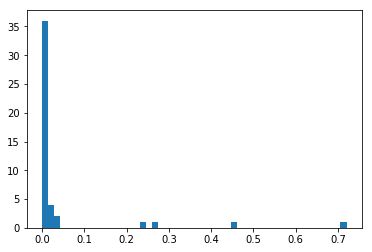

In [18]:
plt.hist(temp, bins=50);

In [20]:
de_pval = pd.DataFrame(
    data=np.vstack([np.load(data_path + 'sex_statistics/{}_de_pvals.npy'.format(ct)) for ct in ct_list]),
    index=ct_list,
    columns=gene_list).T

dv_pval = pd.DataFrame(
    data=np.vstack([np.load(data_path + 'sex_statistics/{}_dv_pvals.npy'.format(ct)) for ct in ct_list]),
    index=ct_list,
    columns=gene_list).T

In [23]:
male_mean = pd.DataFrame(
    data=np.vstack([np.load(data_path + 'sex_statistics/0_{}_ct_mean.npy'.format(ct)) for ct in ct_list]),
    index=ct_list,
    columns=gene_list).T
female_mean = pd.DataFrame(
    data=np.vstack([np.load(data_path + 'sex_statistics/1_{}_ct_mean.npy'.format(ct)) for ct in ct_list]),
    index=ct_list,
    columns=gene_list).T

In [24]:
male_var = pd.DataFrame(
    data=np.vstack([np.diag(np.load(data_path + 'sex_statistics/0_{}_ct_cov.npy'.format(ct))) for ct in ct_list]),
    index=ct_list,
    columns=gene_list).T

female_var = pd.DataFrame(
    data=np.vstack([np.diag(np.load(data_path + 'sex_statistics/1_{}_ct_cov.npy'.format(ct))) for ct in ct_list]),
    index=ct_list,
    columns=gene_list).T

In [43]:
male_mean.head(50)

,Tc,Th,NK,cM,B
IGBP1,0.205445,0.620916,-0.259291,0.411444,0.272491
SEPT6,0.589342,0.971073,0.600552,-0.508467,0.811253
CD99,1.906733,1.066916,2.129488,1.457528,0.410809
NDUFA1,1.562371,1.521130,1.529313,1.739067,1.214779
RPL36A,2.879811,3.282653,1.990548,2.700753,2.922962
RBM3,1.724559,1.787131,1.687115,1.892655,1.672513
RPL10,5.351280,5.753423,4.735317,5.085696,5.443328
UXT,1.493558,1.877224,0.957006,1.448096,1.527313
IL2RG,1.559105,1.319930,1.868991,-0.564375,1.074505
LAMP2,-1.501857,-1.751944,-1.468580,0.493603,-1.922802


In [44]:
female_mean.head(50)

,Tc,Th,NK,cM,B
IGBP1,0.408726,0.524103,0.005278,0.458091,0.230193
SEPT6,1.069545,1.308364,0.790662,-0.232274,0.865452
CD99,1.914880,0.899261,2.161598,1.392560,0.272283
NDUFA1,1.817293,1.542535,1.711103,2.066437,1.317741
RPL36A,3.198342,3.337264,2.234076,2.997697,3.106260
RBM3,1.655556,1.594261,1.637393,1.847560,1.627189
RPL10,5.464819,5.692911,4.832562,5.118875,5.444840
UXT,1.619405,1.802668,1.071899,1.478939,1.553216
IL2RG,1.967603,1.505417,2.123374,-0.361544,1.187019
LAMP2,-1.361192,-1.517989,-0.986474,0.798317,-1.575133


### Perform FDR correction

In [29]:
def fdr_correct_df(df):
    
    _df = df.copy()
    
    pvals = df.values.reshape(-1)
    fdr = np.full_like(pvals, np.nan)
    _, fdr[~np.isnan(pvals)] = fdrcorrection(pvals[~np.isnan(pvals)])
    _df.loc[:, :] = fdr.reshape(df.shape)
    return _df

In [30]:
de_fdr = fdr_correct_df(de_pval)
dv_fdr = fdr_correct_df(dv_pval)

### Define the significance threshold

In [277]:
sig_threshold = 0.15
de_sig = (de_fdr < sig_threshold)
dv_sig = (dv_fdr < sig_threshold)

### Function for plotting expression & variance

In [278]:
def plot_exp(gene, width=0.2):
    
    plt.figure(figsize=(15, 3));
    
    plt.subplot(1, 2, 1)
    
    male_pos = np.arange(0, 5)
    female_pos = np.arange(width, 4.5)
    
    print(de_fdr.loc[gene])
    print(dv_fdr.loc[gene])
    
    plt.bar(male_pos, male_mean.loc[gene], width=width)
    plt.bar(female_pos, female_mean.loc[gene], width=width)
    
    plt.legend(['male', 'female'])
    plt.xticks(male_pos + width/2, ct_list)
    
    plt.title('Expression of {}'.format(gene))
    
    plt.subplot(1, 2, 2)
    
    plt.bar(male_pos, male_var.loc[gene], width=width)
    plt.bar(female_pos, female_var.loc[gene], width=width)
    
    plt.legend(['male', 'female'])
    plt.xticks(male_pos + width/2, ct_list)
    
    plt.title('Variance of {}'.format(gene))

### CD99, Th specific X inactivation

Tc    0.789691
Th    0.018016
NK    0.505224
cM    0.083995
B     0.149716
Name: CD99, dtype: float64
Tc    0.583456
Th    0.088667
NK    0.279964
cM    0.176612
B     0.393597
Name: CD99, dtype: float64


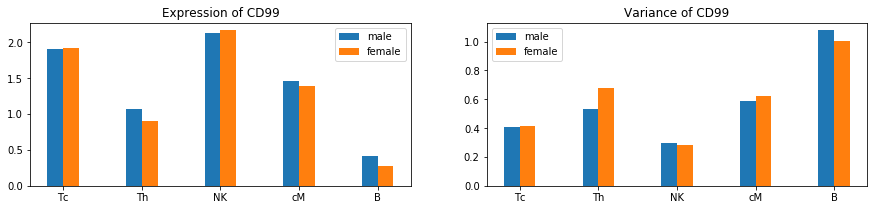

In [279]:
plot_exp('CD99')

### X - escape gene

In [286]:
escape_pattern = (dv_sig & dv_sig)
escape_pattern[escape_pattern.sum(axis=1) > 1].head(5)

,Tc,Th,NK,cM,B
SEPT6,True,True,False,False,False
NDUFA1,True,True,True,True,False
RPL36A,True,True,True,False,True
RBM3,False,True,False,True,False
RPL10,True,True,True,False,False


Tc    0.0
Th    0.0
NK    0.0
cM    0.0
B     0.0
Name: EIF1AX, dtype: float64
Tc    0.075840
Th    0.083552
NK    0.139491
cM    0.083552
B     0.118169
Name: EIF1AX, dtype: float64


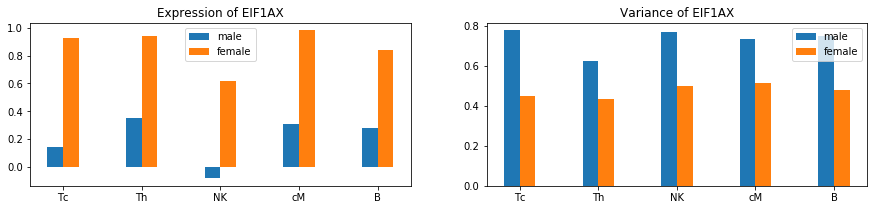

In [281]:
plot_exp('EIF1AX')

### X-inactivation

In [282]:
inactivation_pattern = (~de_sig) & dv_sig & (female_var > male_var)
inactivation_pattern[inactivation_pattern.sum(axis=1) > 0]

,Tc,Th,NK,cM,B
FUNDC2,False,True,False,True,False
SLC25A5,False,False,False,True,False
TSC22D3,True,False,False,False,False
SLC25A6,False,False,False,True,False
PGK1,False,False,True,False,False
ATP6AP2,False,True,False,False,True


Monocyte specific X-inactivation
Tc    0.083242
Th    0.043025
NK    0.834799
cM    0.008819
B     0.859877
Name: RPL9, dtype: float64
Tc    0.150138
Th    0.052538
NK    0.150138
cM    0.038429
B     0.150138
Name: RPL9, dtype: float64


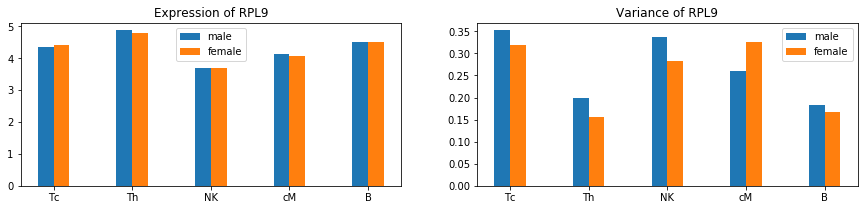

In [283]:
print('Monocyte specific X-inactivation')
plot_exp('RPL9')